# Problem set 2

## Team
Please write here your names and team number.

* Team name:
* Team members:

## Using Colab with GitHub
To utilize GPU support for model training, we highly recommend to open this notebook with Google Colab. Simply, change the domain from 'github.com' to 'githubtocolab.com' and refresh the site to open the notebook in Colab.
If you haven't used Colab before with private repositories, make sure to grant Colab access to your private repositories (see screenshot) and after that just try to change the domain again.

Finally, you should make sure that you add a GPU to your Colab notebook. You can do so by clicking on `Runtime` →  `Change runtime type` → `Hardware accelerator`  →  `GPU`.

## Submission

Make sure that you always commit and push the changes you make in Colab back to GitHub. To do so from within a Colab notebook, click `File` → `Save a copy in GitHub`. You will be prompted to add a commit message, and after you click OK, the notebook will be pushed to your repository. Only changes that are visible in your GitHub repository on the main branch will be considered for grading. If you close Colab in your browser without pushing your changes to GitHub or saving them on Google Drive, they will be lost.

Make sure that all your work has been pushed to GitHub before the deadline.


Check that the GPU  enabled in your colab notebook by running the cell below.

In [1]:
import torch
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


You will be working with the EuroSAT dataset. The dataset contains 8489 pictures of 3 different land coverage types (crop, herbaceous vegetation and river). Running the lines below will download the data and return a random picture from the dataset.

The dataset has 27000 images
Picture number 2757 with label: 0


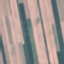

In [2]:
from torchvision.datasets import EuroSAT
import os
import numpy as np

data = EuroSAT(root=os.getcwd(), download=True) #downloads the dataset to your current directory
print(f"The dataset has {len(data)} images")
randint = np.random.randint(len(data))

pic, tar = data[randint]
print(f"Picture number {randint} with label: {tar}")
pic

# Task 1: Transform the data (10 pt)

 Your task is to train a classifier to classify the different land usage types in the dataset. We want to select only the 50 most frequent people in the dataset, all the other people should be mapped to a common class.
- Implement the class `rotate` that maps pictures to flipped pictures by 90, 180, 270 or 360°. The class should return an error if you try to rotate the picture by other degrees. 
- Plot a histogram with the frequencies of each class. Make sure to insert both name and label in the histogram (e.g. `AnnualCrop:0`).
- We create a class `RotateEuroSAT` that takes as input the original dataset and returns a new dataset which contains randomly rotated pictures and whose label proportion can be customized. 
Implement the class method `_create_rotated_dataset` that returns this pictures using the previously implemented `rotate`.
- `RotateEuroSAT` should also take care of transforming the pictures to tensors and optionally move the tensor to a GPU device.

C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_5252\394898418.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


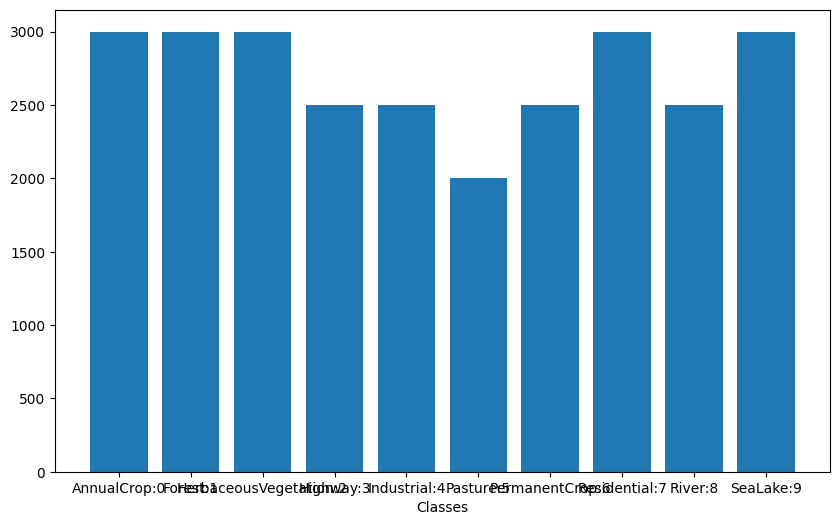

In [6]:
from torch.utils.data import Subset, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np

def rotate_picture(picture, rotation):
  '''#TODO: implemented most frequent n people'''
  ### BEGIN SOLUTION ###
  assert rotation in [90, 180, 270, 360], "Rotation must be one of [90, 180, 270, 360] degrees"
  new_picture = picture.rotate(angle=rotation)
  ### END SOLUTION ###

  return new_picture


def plot_histogram(data):
  '''#TODO: here your code'''
  fig, ax = plt.subplots(figsize=(10, 6))
  ### BEGIN SOLUTION ###
  targets_arr = np.array(data.targets)
  idx_to_class = {v: k for k, v in data.class_to_idx.items()}
  _, counts = np.unique(targets_arr, return_counts=True)
  
  ax.bar(range(len(counts)), 
         counts, 
         tick_label=[f"{idx_to_class[i]}:{i}" for i in range(len(counts))])
  ax.set_xlabel('Classes')
  ### END SOLUTION ###

  return fig, ax


new_pic = rotate_picture(pic, 90) # Example of rotating a picture by 90 degrees
same_pic = rotate_picture(pic, 360) # Example of rotating a picture by 360 degrees (should return the same picture)             
fig, ax = plot_histogram(data)
fig.show()

Text(0.5, 1.0, 'Rotated by 360°')

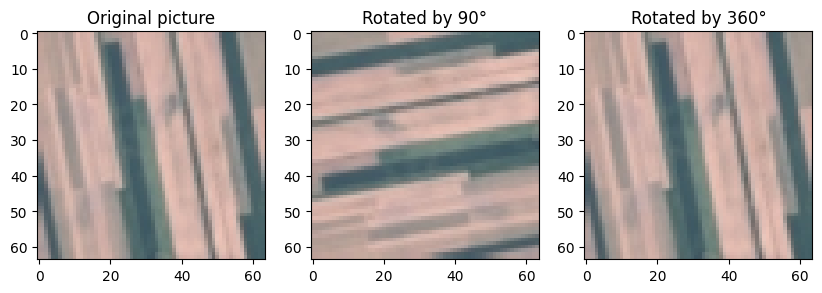

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))

axes[0].imshow(pic)
axes[0].set_title("Original picture")
axes[1].imshow(new_pic)
axes[1].set_title("Rotated by 90°")
axes[2].imshow(same_pic)
axes[2].set_title("Rotated by 360°")

In [8]:
from torchvision import transforms

class RotateEuroSAT(Dataset):
    def __init__(self, 
                 original_data:Dataset, 
                 length:int, 
                 shares:list,
                 device=None,
                 seed=42):
        
        self.original_data = original_data
        self.length = length
        assert sum(shares)  == 1, "Shares must sum to 1"
        assert len(shares) == len(original_data.classes), "Shares must match number of classes"
        self.shares = shares
        self.seed = seed
        self.device = device
        self.dataset = self._create_rotated_dataset()

    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        picture, label = self.dataset[idx]
        return picture, label
    
    def _create_rotated_dataset(self):
        ### BEGIN SOLUTION ###
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])    
        np.random.seed(self.seed)
        dataset = []

        class_sizes = [int(share * self.length) for share in self.shares]
        if sum(class_sizes) != self.length:
            class_sizes[0] += self.length - sum(class_sizes)  # Adjust for rounding errors

        for class_idx, class_size in enumerate(class_sizes):
            class_data = Subset(self.original_data, 
                                [i for i, target in enumerate(self.original_data.targets) if target == class_idx])
            selected_indices = np.random.choice(len(class_data), class_size, replace=True)
            for idx in selected_indices:
                picture, label = class_data[idx]
                rotation = np.random.choice([90, 180, 270, 360])
                rotated_picture = rotate_picture(picture, rotation)
                tensor = transform(rotated_picture).to(self.device)
                dataset.append((tensor, label))
                
        return dataset
        ### END SOLUTION ###    

In [9]:
rotated_data = RotateEuroSAT(data, 
                             length=10**4, 
                             shares=[1 / len(data.classes) for _ in data.classes], 
                             seed=42)

train_data, test_data = random_split(rotated_data, [0.8, 0.2])

## Task 2: Implement a max pooling class and a CNN model(15 pt)
Implement a classification model to predict the label of the faces in the dataset. You are free to experiment with the network architecture. However your model **must** contain:
- At least one max pooling layer, implemented with `MyMaxPool`,
- Convolutional, linear, and pooling layers only,
- At least 3 convolutional layers, with at least two different kernel sizes,
- A final output layer that is customizable to the number of classes that we want to predict.

#### Briefly explain why you chose the particular architecture you implemented (around 2-3 sentences).


In [10]:
import torch
import torch.nn as nn
import torch.functional as F
class MyMaxPool(nn.Sequential):

  def __init__(self,
               kernel_size, 
               stride=1, 
               padding=0):
    
    super().__init__()
    ### BEGIN SOLUTION ###
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    ### END SOLUTION ###
  
  def forward(self, x):
    ### BEGIN SOLUTION ###
    if self.padding: #automatically pads the last 2 dim
      x = F.pad((self.padding, self.padding, self.padding, self.padding))
    
    if x.dim() < 4:
      x = x.unsqueeze(0)
    
    N, C, H, W = x.shape
    H_out = (H - self.kernel_size)//self.stride + 1
    W_out = (W - self.kernel_size)//self.stride + 1
    
    out = torch.zeros((N, C, H_out, W_out))
    out = out.to(x.device)
    
    for n in range(N):
      for c in range(C):
        for i in range(0, H_out):
          for j in range(0, W_out):
            h0 = i * self.stride
            h1 = h0 + self.kernel_size
            w0 = j * self.stride
            w1 = w0 + self.kernel_size
            out[n,c,i,j] = x[n,c,h0:h1, w0:w1].max()    
    ### END SOLUTION ###
    
    return out

        

In [11]:
class MyCNNModel(nn.Sequential):

  def __init__(self,
               n_classes):
    
    super().__init__()
    ### BEGIN SOLUTION ###
    layers = [
      # Conv layer 1
        nn.Conv2d(in_channels=3,
                out_channels=16,
                kernel_size=3,
                stride=1, padding=0),
        nn.ReLU(),
        MyMaxPool(kernel_size=2, stride=2),
        
        # Conv layer 2
        nn.Conv2d(in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1, padding=0),
        nn.ReLU(),
        MyMaxPool(kernel_size=2, stride=2),
        
        # Conv layer 3
        nn.Conv2d(in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1, padding=0),
        nn.ReLU(),
        MyMaxPool(kernel_size=2, stride=2),

        # Flatten and output layer
        nn.Flatten(),  # Flatten before fully connected layer
        # Fully connected layer
        nn.LazyLinear(64),  # calling lazy linear if we don't know the inp size
        nn.ReLU(),
        nn.Linear(64, n_classes)
    ]
    
    super().__init__(*layers)

    ### END SOLUTION ###
  
  def forward(self, x):
    ### BEGIN SOLUTION ###
    out = super().forward(x)
    return out
  
    ### END SOLUTION ###


In [12]:
'''#TODO: print one iteration of your model to test its correctness'''

my_model = MyCNNModel(n_classes=10)
X, y = train_data[0]
my_model(X)

tensor([[-0.0682, -0.1098, -0.0638, -0.0098,  0.0746,  0.0251,  0.0462, -0.0094,
         -0.0358, -0.0117]], grad_fn=<AddmmBackward0>)

## Training

We define a `Trainer` function to train our model that returns avg loss and avg accuracy per epoch. We set the configuration of the trainer is set in the `cfg` dictionary. Use the trainer to train your model and make sure to print and plot avg loss and accuracy using the in-built commands.

In [15]:
from datetime import datetime as dt
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

cfg = {
    'batch_size': 64,
    'criterion': 'CrossEntropyLoss', #change to 'nn.NLLLoss' if you are applying a softmax in the last layer of your model
    'epochs': 1,
    'learning_rate': 0.001,
    'optimizer':'Adam',
    'seed':42,

}

class Trainer:

    def __init__(self, model, cfg):
        self.model = model
        self.cfg = cfg

        for key, val in cfg.items():
            setattr(self, key, val)

        self.optimizer = getattr(optim, self.optimizer)(self.model.parameters(), lr=self.learning_rate)
        self.criterion = getattr(nn, self.criterion)()


    def iter_step(self, X, Y):
        Y_pred = self.model(X)
        loss = self.criterion(Y_pred, Y)
        acc = (Y_pred.argmax(dim=-1) == Y).to(torch.float).mean()
        return loss, acc

    def train(self, dataset):
        train_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))
        avg_loss, avg_acc = [], []
        
        for epoch in range(self.epochs):
            epoch_loss, epoch_acc = 0, 0
            iterdata = iter(train_dataloader)
            train_size = len(iterdata)
            pbar = tqdm(iterable=range(train_size))

            for i in pbar:
                batch = next(iterdata)
                X_batch, Y_batch = batch #this is needed for compatibility with pbar
                self.model.train()
                self.optimizer.zero_grad()
                loss, acc = self.iter_step(X_batch, Y_batch)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                epoch_acc += acc.item()
                avg_loss.append(epoch_loss / len(dataset))
                avg_acc.append(epoch_acc / len(dataset))
                desc = f'Epoch:{epoch} - Avg loss:{avg_loss[-1]:.5f} - Avg acc:{avg_acc[-1]:.5f}'
                pbar.set_description(desc)

        return avg_loss, avg_acc

    def test(self, dataset):
        avg_test_loss, avg_test_acc = [], []
        test_loss, test_acc = 0, 0
        self.model.eval()
        test_dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True, generator=torch.manual_seed(self.seed))

        for X_batch, Y_batch in iter(test_dataloader):
            loss, acc = self.iter_step(X_batch, Y_batch)
            test_loss += loss.item()
            test_acc += acc
            avg_test_loss.append(test_loss / max(1, len(avg_test_loss)))
            avg_test_acc.append(test_acc / max(1, len(avg_test_acc)))

        return avg_test_loss, avg_test_acc



In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
my_trainer = Trainer(my_model, cfg)
train_loss, train_acc = my_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = my_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')

## Task 3: Tune your model hyperparameters (optional, 10 pt)

Implement a method <code>grid_search</code>, which looks for the best possible learning rates and training batch sizes for your model <code>MyCNNModel</code> and returns the best possible model, the corresponding training configuration, and the final training avg losses and accuracies (as numbers).

In [ ]:
def grid_search(train_dataset, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7]):
    ### BEGIN SOLUTION ###
    best_avg_acc = 0
    best_avg_loss = float('inf')
    best_model = None
    best_cfg = None
    
    for lr in learning_rates:
        for bs in batch_sizes:
            # Create a copy of cfg and update learning rate and batch size
            new_cfg = dict(cfg)
            new_cfg['lr'] = lr
            new_cfg['batch_size'] = bs

            # Instantiate new model and trainer
            model = MyCNNModel(n_classes=10)
            trainer = Trainer(model, new_cfg)

            # Train the model
            train_loss, train_acc = trainer.train(train_dataset)

            # Use the avg of the last 10 accuracies/losses for comparison (or last one if less than 10 samples)
            if len(train_acc) >= 10:
                avg_acc = sum(train_acc[-10:]) / 10
                avg_loss = sum(train_loss[-10:]) / 10
            else:
                avg_acc = train_acc[-1]
                avg_loss = train_loss[-1]

            # Update best if better
            if avg_acc > best_avg_acc or (avg_acc == best_avg_acc and avg_loss < best_avg_loss):
                best_avg_acc = avg_acc
                best_avg_loss = avg_loss
                best_model = model
                best_cfg = new_cfg

    return best_model, best_cfg, best_avg_loss, best_avg_acc


best_model, best_cfg, best_avg_loss, best_avg_acc = grid_search(train_data, cfg, learning_rates=[10**-1, 10**-2, 10**-3], batch_sizes=[2**5, 2**6, 2**7])
print(f"Best model achieves {best_avg_loss:.2f} loss and {best_avg_acc:.1%} accuracy")


## Task 3: Load and fine-tune a pre-trained model (10 pt)

<ul>
  <li>Load and train a pre-trained model for classification problems, such as those made available in <a href="https://huggingface.co/docs/timm">Hugging Face's timm library</a>. </li>
  <li> Make sure to modify the output layer to be compatible with the number of classes. </li>
  <li>Print a summary of your results.</li>
  <li>Briefly explain why you chose the particular architecture you did (around 2-3 sentences).</li>
  </ul>
  
<b>Note</b>: in case you run into computing-related (e.g. memory) issues, consider choosing another model.

In [ ]:
### BEGIN SOLUTION ###

%pip install timm --q
import timm
import torch.nn as nn

# Choose a model compatible with small RGB images, e.g., resnet18
# Make sure the model can take (3, 64, 64) images as input

# Load a pretrained resnet18
loaded_model = timm.create_model('resnet18', pretrained=True)

# Modify the final layer to output 10 classes, as in EuroSAT
num_features = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_features, 10)


### END SOLUTION ###
loaded_trainer = Trainer(loaded_model, cfg)


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


c:\Users\c.fusarbassini\Desktop\Deep Learning WS 2025\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
c:\Users\c.fusarbassini\Desktop\Deep Learning WS 2025\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\c.fusarbassini\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the

In [ ]:
'''#TODO: train your model, plot accuracy and loss by iteration (one iteration=one batch)'''
train_loss, train_acc = loaded_trainer.train(train_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(train_loss)), train_loss)
ax1.plot(range(len(train_acc)), train_acc)
ax0.set_title('Training loss')
ax1.set_title('Training accuracy')

In [ ]:
'''#TODO: test your model, plot accuracy and loss by iteration (one iteration=one batch)'''
test_loss, test_acc = loaded_trainer.test(test_data)
fig, (ax0, ax1) = plt.subplots(1,2)
ax0.plot(range(len(test_loss)), test_loss)
ax1.plot(range(len(test_acc)), test_acc)
ax0.set_title('Test loss')
ax1.set_title('Test accuracy')


<a name="results-and-discussion"></a>
# Task  4: Results and discussion (5pt)

Report the final metrics and make a few comments on the overall performance for the networks you implemented (3-4 lines).

| Test metric         | your model | pre-trained model | your tuned model (optional) |
|---------------------|--------------------|-------------------|-----------------------|
| Accuracy (train)           |              |             |                |                     
| Loss (train)               |               |             |                |    
| Accuracy (test)           |              |             |                |                     
| Loss (test)               |               |             |                |              
             



